In [118]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import layers, models, callbacks
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sentence_transformers import SentenceTransformer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/i551965/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/i551965/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/i551965/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Spam E-Mail Detector
This notebooks contains a model which is able to predict whether a given embedding of an email is a Phishing Mail or is safe. To achieve this, it loads previously created embeddings of emails that are classified either as Phishing or Safe. It then splits up the data into a train, validate and test split before defining and training a model with the data. Finally the models performance is evaluated. The basic structure is oriented towards CRISP DM.
## CRISP-DM Phasen

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment


## Kontext
### Georgiev International GmbH 
Kleines Eisenguss Unternehmen, welches sich vor einem Jahr seine IT-Infrastruktur aufgesetzt hat. Leider erhält dieses Unternehmen viele Spam Mails aus Bulgarien. Daher wurden die Studenten der DHBW beauftragt ein Spam Filter für deren Gmail Accounts zu entwickeln.

### 1. Business Understanding

##### Aufgbabe
Entwicklung eines Modells, das vorhersagen kann, ob eine Email Phishing ist oder nicht.

##### Ziele
- Reduzieren der Anzahl an Phishing Mails, die in der Inbox des Nutzers landen.
- Minimieren von False Positives um sicherzustellen, dass legitime Emails nicht fälschlicherweise als Phishing gekennzeichnet werden.
- Verbessern des allgemeinen Nutzervertrauens

##### Erfolgskriterien
- Erreichen einer Genauigkeit von über 90%
- False Positive Rate unter 5%
- False Negative Rate unter 2%

##### Stakeholder
- Geschäftsführer der Georgiev International GmbH "Marco"

##### Benötigt werden
- Zugang zu historischen Email-Daten mit gelabelten Beispielen von Phishing und Non-Phishing Emails.
- Infrastruktur zum Entwickeln, Testen und Produktiv Setzen des Modells.

### 2. Data Understanding
Die Daten kommen aus folendem Datensatz: https://www.kaggle.com/datasets/subhajournal/phishingemails/data. 

- 18.600 E-Mails im Datensatz
- 61% sicher, 39% Phishing
- Moderates Ungleichgewicht
- Gefahr von Modell-Bias zugunsten sicherer E-Mails
- 3% leere E-Mails

Der Datensatz enthält drei Spalten:
    
1. Die Anzahl an Einträgen
2. Den Email Text
3. Das Email Label

In [119]:
data = pd.read_csv("data/Phishing_Email.csv", skiprows=0)
data_size = len(data)

print(f"The amount of data entries is: {data_size}\n")
print(data.head())

The amount of data entries is: 18650

   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  


### 3. Data Preparation
Da ungefähr 3% des Datensatzes aus leeren Emails besteht, macht es Sinn, diese zu löschen.

#### Entfernen von leeren Datensätzen

In [120]:
# Printing amount of data before and after to verify that the data has been removed
print(f"Amount of data before: {len(data)}")

# Remove rows with missing text
data = data.dropna(subset=["Email Text"])

print(f"Amount of data after: {len(data)}")

Amount of data before: 18650
Amount of data after: 18634


#### Lösen des Data Imbalance Problems durch Löschen überschüssiger Safe Emails

In [121]:
excess_safe_mails = data[data['Email Type'] == 'Safe Email'].shape[0] - data[data['Email Type'] == 'Phishing Email'].shape[0]
print(f"Excess Safe Mails before resolving data imbalance: {excess_safe_mails}")

# Filter the DataFrame to get rows with the specified value
filtered_df = data[data['Email Type'] == 'Safe Email']

# Randomly select 100 entries to remove
rows_to_remove = filtered_df.sample(n=excess_safe_mails, random_state=1).index

# Drop the selected entries from the original DataFrame
data = data.drop(rows_to_remove)

excess_safe_mails = data[data['Email Type'] == 'Safe Email'].shape[0] - data[data['Email Type'] == 'Phishing Email'].shape[0]
print(f"Excess Safe Mails after resolving data imbalance: {excess_safe_mails}")
n_safe_mails = data[data['Email Type'] == 'Safe Email'].shape[0]
n_phishing_mail = data[data['Email Type'] == 'Phishing Email'].shape[0]
print(f"Number of Safe Mails: {n_safe_mails}, Number of Phishing Mails: {n_phishing_mail}")

Excess Safe Mails before resolving data imbalance: 4010
Excess Safe Mails after resolving data imbalance: 0
Number of Safe Mails: 7312, Number of Phishing Mails: 7312


#### Datenaufbereitung
Hier werden folgende Datenaufbereitungsschritte unternommen
- Alle Buchstaben zu Kleinbuchstaben machen
- Entfernen von Punktzeichen 
- (Entfernen von Stopwords)
- Stemming
- Lemmatization

In [122]:
def clean_texts(texts):
    # Convert to lowercase
    texts = [text.lower() for text in texts]

    # Remove punctuation
    texts = [text.translate(str.maketrans("", "", string.punctuation)) for text in texts]

    # Remove stop words
    #stop_words = set(stopwords.words('english'))
    #texts = [' '.join(word for word in text.split() if word not in stop_words) for text in texts]

    # Tokenize
    texts = [word_tokenize(text) for text in texts]

    # Stemming
    stemmer = PorterStemmer()
    texts = [[stemmer.stem(word) for word in text] for text in texts]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    texts = [[lemmatizer.lemmatize(word) for word in text] for text in texts]

    # Join tokens back into strings
    texts = [' '.join(text) for text in texts]

    return texts

#### Erstellen der Embeddings
- Nutzen des Sentence Transformer Modells allMiniLM (https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)
- Beim Ersten Durchlaufen des Notebooks werden diese in einer Datei gespeichert, die dann in weiteren Durchläufen ausgelesen wird.

In [123]:
def get_embeddings(texts):
    # Load the sentence transformer model
    sentence_transformer_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    
    # Preprocess the data
    cleaned_texts = clean_texts(texts)

    # Encode the text data to get embeddings
    embeddings = sentence_transformer_model.encode(cleaned_texts, show_progress_bar=True)

    # Convert embeddings to a list of lists with Python floats
    embeddings_list = [list(map(float, embedding)) for embedding in embeddings]

    # Convert embeddings to a single string representation
    embeddings_str_list = [str(embedding) for embedding in embeddings_list]
    
    return embeddings_str_list

# Check if the embeddings exist and if not, create them
if not os.path.exists("data/embeddings.csv"):
    # Create a new DataFrame with a single column for embeddings
    embeddings_df = pd.DataFrame({"embedding": get_embeddings(data["Email Text"].tolist())})

    # Concatenate the label column with the embeddings
    final_df = pd.concat([data["Email Type"].reset_index(drop=True), embeddings_df], axis=1)
    
    # Save the final DataFrame to a CSV file
    final_df.to_csv("data/embeddings.csv", index=False, sep=";")

# Load the embeddings and skip the header
data_embeddings = pd.read_csv('data/embeddings.csv', sep=';', skiprows=0)

#### Erstellen eines Trainings, Validations und Testdatensatzes
Dazu wird die Aufteilung 60% Trainingsdate, 20% Validationsdaten und 20% Testdaten genutzt

In [124]:
def format_and_load_data(train_split=0.6, validate_split=0.2, test_split=0.2):
    # Calculate the number of samples for each dataset split
    train_amount = int(data_size * train_split)
    validate_amount = int(data_size * validate_split)
    
    examples = []

    # Process each embedding
    for _, embedding in data_embeddings.iterrows():
        label = 1 if embedding.iloc[0] == 'Phishing Email' else 0
        embedding_list = [float(i) for i in embedding.iloc[1].strip('[]').split(', ')]
        examples.append((embedding_list, label))

    # Shuffle the examples
    np.random.shuffle(examples)

    # Split data into features and labels
    X, y = zip(*examples)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Split data into training, validation and testing sets
    X_train = X[:train_amount]
    X_val = X[train_amount:train_amount + validate_amount]
    X_test = X[train_amount + validate_amount:]
    y_train = y[:train_amount]
    y_val = y[train_amount:train_amount + validate_amount]
    y_test = y[train_amount + validate_amount:]

    return X_train, y_train, X_val, y_val, X_test, y_test

### 4. Modeling

#### Erstellen eines binären Klassifizierungsmodells, um vorherzusagen, ob eine E-Mail Spam ist.

Das Modell besteht aus drei Schichten:
- Die erste Schicht akzeptiert Eingaben mit der Länge der erstellten Einbettungen.
- Die zweite Schicht akzeptiert Eingaben mit der Länge 128.
- Die dritte Schicht akzeptiert Eingaben mit der Länge 1.

- Ersten beiden Schichten verwenden die ReLU-Aktivierungsfunktion
- Letzte Schicht verwendet Sigmoid.
    - Sigmoid wurde gewählt, weil es Werte zwischen 0 und 1 ausgibt, was es für binäre Klassifizierungsaufgaben geeignet macht. (Es wird auch sehr häufig für diese Art von Aufgaben verwendet.)

Die Daten werden aufgeteilt in:
- Training (60%)
- Validierung (20%)
- Testsets (20%)

Während des Trainings werden die Validierungsdaten und der Validierungsverlust verwendet, um das Modell nach jeder Epoche zu bewerten. Die Validierungsgenauigkeit wurde ebenfalls berücksichtigt, zeigte jedoch schwächere Ergebnisse als die Verlustmetrik.

Um den Trainingsprozess effektiv zu verwalten, werden zwei Callback-Funktionen verwendet:
- **Early Stopping**: Stoppt das Training, wenn die Leistung des Modells, gemessen am Validierungsdatensatz, zu verschlechtern beginnt, um Überanpassung zu verhindern.
- **Reduce Learning Rate on Plateau**: Passt die Lernrate an (in diesem Fall, indem sie halbiert wird), wenn die Leistung des Modells zu sinken beginnt, um zu verhindern, dass es in lokalen Minima stecken bleibt. Der Geduld-Parameter für beide Callbacks definiert die Anzahl der Epochen, die sie abwarten, bevor sie Maßnahmen ergreifen.

In [125]:
# Load the data splits
X_train, y_train, X_val, y_val, X_test, y_test = format_and_load_data()

# Reshape data to make it acceptable for the model
y_train = np.array(y_train, dtype=np.int32)
y_val = np.array(y_val, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

print(X_train.shape, X_train[0].shape)

# Define model architecture
no_embedding_dim = len(X_train[0])
model = models.Sequential([
    layers.Dense(no_embedding_dim, activation='relu', input_shape=(no_embedding_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=2, monitor='val_loss', verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# Save the model for later use
model.save("models/phishing_email_classifier.h5")

model_summary = model.summary()
model_summary

(11190, 384) (384,)
Epoch 1/50


/Users/i551965/Library/CloudStorage/OneDrive-SAPSE/BachelorStudium/DHBW/6.Semester/KI/KI-PhishingMailDetector/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8362 - loss: 0.3461 - val_accuracy: 0.9279 - val_loss: 0.1809 - learning_rate: 0.0010
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9437 - loss: 0.1455 - val_accuracy: 0.9381 - val_loss: 0.1569 - learning_rate: 0.0010
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9620 - loss: 0.1033 - val_accuracy: 0.9416 - val_loss: 0.1498 - learning_rate: 0.0010
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9740 - loss: 0.0676 - val_accuracy: 0.9405 - val_loss: 0.1799 - learning_rate: 0.0010
Epoch 5/50
330/350 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9811 - loss: 0.0444
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9810 - loss: 0.0445 - val_accuracy: 0.9402 - val_loss: 0.1915 - learning_rate: 0.0010
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9861 - loss: 0.0297 - val_accuracy

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 384)            │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 616,325 (2.35 MB)

 Trainable params: 205,441 (802.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 410,884 (1.57 MB)

### 5. Evaluation

In [126]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#### Loss and accuracy
- **Verlust (Loss)**: Misst die Differenz zwischen vorhergesagten und tatsächlichen Werten.

- **Genauigkeit (Accuracy)**: Gibt an, wie oft das Modell korrekte Vorhersagen trifft.

In [127]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.1379
Test Accuracy: 0.9456


#### F1-Score
Der F1-Wert berechnet sich als harmonisches Mittel zwischen Precision und Recall, die jeweils wie folgt berechnet werden:

- **Precision**: Die Precision misst das Verhältnis der korrekt als positiv vorhergesagten Instanzen zur Gesamtanzahl der positiv vorhergesagten Instanzen. Sie wird berechnet als:
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$
  Dabei sind \(TP\) die richtig positiven Vorhersagen (true positives) und \(FP\) die falsch positiven Vorhersagen (false positives).

- **Recall**: Der Recall (auch Sensitivität genannt) misst das Verhältnis der korrekt als positiv vorhergesagten Instanzen zur Gesamtanzahl der tatsächlich positiven Instanzen. Er wird berechnet als:
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

  Hierbei sind \(TP\) die richtig positiven Vorhersagen und \(FN\) die falsch negativen Vorhersagen (false negatives).

- **F1-Score**:
  $$
  \text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

In [128]:
# Evaluate the model on test data
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(np.int32)

# Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
Precision: 0.9187
Recall: 0.9419
F1 Score: 0.9302


#### ROC AUC Score

- **ROC-AUC (Receiver Operating Characteristic - Area Under the Curve)**: Der ROC-AUC-Wert misst die Fähigkeit eines binären Klassifikators, zwischen positiven und negativen Klassen zu unterscheiden, unabhängig von der gewählten Klassifikationsschwelle.

  Der ROC-AUC-Wert wird berechnet, indem die Fläche unter der ROC-Kurve betrachtet wird. Die ROC-Kurve zeigt das Verhältnis von True Positive Rate (TPR) zu False Positive Rate (FPR) für verschiedene Klassifikationsschwellen. Ein höherer ROC-AUC-Wert (normalerweise im Bereich von 0 bis 1) deutet auf ein besseres Modell hin, das besser zwischen den Klassen unterscheiden kann.

  Eine ROC-AUC von 0,5 bedeutet, dass das Modell nicht besser als zufällige Vorhersagen ist, während ein Wert nahe 1 zeigt, dass das Modell eine sehr gute Trennung zwischen den Klassen erreicht hat.


In [129]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC Score: {roc_auc:.4f}')

ROC AUC Score: 0.9884


#### Confusion Matrix

- **True Positives (TP)**: Korrekt als positiv vorhergesagte Instanzen.
- **False Positives (FP)**: Fälschlicherweise als positiv vorhergesagte Instanzen.
- **True Negatives (TN)**: Korrekt als negativ vorhergesagte Instanzen.
- **False Negatives (FN)**: Fälschlicherweise als negativ vorhergesagte Instanzen.


Ein Beispiel für die Darstellung einer Confusion Matrix:

|                 | Predicted Negative | Predicted Positive |
|-----------------|--------------------|--------------------|
| **Actual Negative** | TN                 | FP                 |
| **Actual Positive** | FN                 | TP                 |


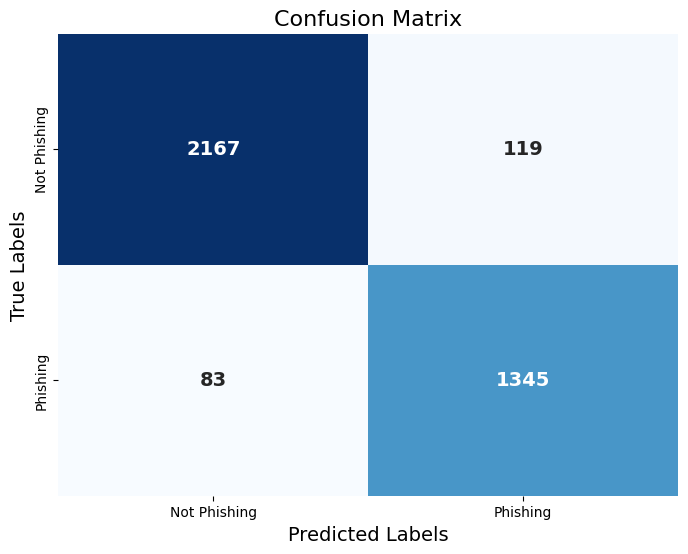

In [130]:
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(ticks=[0.5, 1.5], labels=['Not Phishing', 'Phishing'])
plt.yticks(ticks=[0.5, 1.5], labels=['Not Phishing', 'Phishing'])
plt.show()

#### Zusammenfassung der Evaluation

### 6. Deployment
Das Modell kann zur Nutzung aus dem models Ordner geladen und dann genutzt werden. Nachfolgend ist beispielhaft die Nutzung des Modells gezeigt.

In [131]:
# Load the saved model for phishing email classification
model = keras.models.load_model("models/phishing_email_classifier.h5")

# Creating sample mails on my own to test and demonstrate the model
mails = ["You won the lottery! Please send us your bank account details to claim your prize.",
         "Hello I am a Nigerian prince and I want to share my fortune with you. Please send me your bank account details so I can transfer the money to you.",
         "Hello I am just confirming that I got your previous email and I will get back to you soon. Thanks.",
         "Hey, I am not feeling too good and will take tomorrow off."]

# Encode the preprocessed email text to get its embedding
email_embeddings = get_embeddings(mails)

email_embeddings_formatted = []
# Process each embedding
for ee in email_embeddings:
    embedding_list = [float(i) for i in ee.strip('[]').split(', ')]
    email_embeddings_formatted.append(embedding_list)
    
email_embeddings_formatted = np.array(email_embeddings_formatted)

# Make predictions for each embedding
predictions = model.predict(email_embeddings_formatted)

# Thresholding the predictions
threshold = 0.5
predicted_labels = ["Phishing" if prediction[0] >= threshold else "Safe" for prediction in predictions]

# Print predictions for each mail
for mail, prediction in zip(mails, predicted_labels):
    print(f"Mail: {mail}\nPrediction: {prediction}\n")

/Users/i551965/Library/CloudStorage/OneDrive-SAPSE/BachelorStudium/DHBW/6.Semester/KI/KI-PhishingMailDetector/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 1/1 [00:00<00:00, 30.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Mail: You won the lottery! Please send us your bank account details to claim your prize.
Prediction: Phishing

Mail: Hello I am a Nigerian prince and I want to share my fortune with you. Please send me your bank account details so I can transfer the money to you.
Prediction: Phishing

Mail: Hello I am just confirming that I got your previous email and I will get back to you soon. Thanks.
Prediction: Safe

Mail: Hey, I am not feeling too good and will take tomorrow off.
Prediction: Phishing

